***
<h1 id="heading"><center><span style="background-color:#5642C5; color:white ; display:fill;border-radius:5px; font-family:cursive"> Children vs adults</span></center></h1>
<p><center style="color:#159364; font-family:cursive;">“Pursue excellence, and success will follow.” – Rancho</center></p>

***

In [1]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#        print(os.path.join(dirname, filename))


<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive">  💡🔥🌟 Import nessecery package 📥💻</span></h3>


In [1]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as T
import torch.nn.functional as F
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
%matplotlib inline



    1.0 Import Packages
    2.0 Show Number of Images Per Label
    3.0 Show Sample Images of Each Label
    4.0 Show Augmented Images, That Can Reduce Overfitting
    5.0 Get Augmented Images using Image Data Generator
    6.0 Get Transfer Learning Model - MobileNetV2
    7.0 Building Deep Neural Network Architecture with MobileNetV2
    8.0 Tune Learning Rate
    9.0 Training Model with Calibrated Learning Rate
    10.0 Visualise Model Performance
    11.0 What Computer see during training convolutional images
    12.0 Test Your Own Images





<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive">  Config parametre 📥💻</span></h3>


In [2]:
random_seed = 42
batch_size=30
val_size = 40

<h1 id="heading"><span style="background-color:#50b5e7; color:white ; display:fill;border-radius:5px; font-family:cursive"> 1. 🏆🏅 Data Analysis & Exploring 📊🔬</span><a class="anchor-link" href="https://www.kaggle.com/shubhamksingh/formatting-notebooks-tutorial-html-markdown/notebook#basics">¶</a></h1>



<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive"> 👨‍‍🔧 Data analysis 🔋🗄️ </span></h3>


In [3]:
data_dir = '/kaggle/input/children-vs-adults-images'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['adults', 'children']


In [4]:
children_files = os.listdir(data_dir + "/train/children")
adults_files = os.listdir(data_dir + "/train/adults")
print('No. of training examples for children:', len(children_files))
print(children_files[:5])
print('\n No. of training examples for adults:', len(adults_files))
print(adults_files[:5])

No. of training examples for children: 340
['208.jpg', '333.jpg', '369.jpg', '89.jpg', '275.jpg']

 No. of training examples for adults: 340
['208.jpg', '333.jpg', '369.jpg', '89.jpg', '275.jpg']



<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive"> 👨‍‍🔧 Data Preprocessing Pipline 🔋🗄️ </span></h3>


<span style="background-color:#e7ccf2; color:white ;border-radius:5px; font-family:cursive"> Data Augmentation techniques for images</span> we can use:

* **Geometric transformations** – you can randomly flip, crop, rotate or translate images, and that is just the tip of the iceberg
* **Color space transformations** – change RGB color channels, intensify any color
* **Kernel filters** – sharpen or blur an image 
* **Random Erasing** – delete a part of the initial image
* **Mixing images** – basically, mix images with one another. Might be counterintuitive but it works

<span style="background-color:#e7ccf2; color:white ;border-radius:5px; font-family:cursive"> 🗃️⬆️ Data augmentation library 🗄️ </span>

- [ ] **Augmentor**
- [x] **Albumentations**
- [ ] **Imgaug**
- [ ] **AutoAugment** (DeepAugment)
- [x] **torchvision.transforms**

<span style="background-color:#e7ccf2; color:white ;border-radius:5px; font-family:cursive"> **steps:**</span>
- [ ] A validation split of 15% is selected
- [ ] Random crops of size 512 × 512 are extracted randomly out of the original images ,We opt for a dynamic augmented data set, where training samples are generated randomly at the start of each mini-batch.
- [ ] We artificially grow our data set by a factor of 8 through rotation at 90, 180 and 270 degrees and horizontal flips
- [ ] We have implemented elastic deformation by sampling control points on a regularly spaced 100 × 100 grid. Each control point has isotropic Gaussian noise added with σ = 20


<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive"> 🏋️‍♂️ training Preprocessing Pipline 🔋🗄️ </span></h3>


In [5]:
# def model_pipeline(hyperparameters):

#     # tell wandb to get started
#     with wandb.init(project="pytorch-demo", config=hyperparameters):
#       # access all HPs through wandb.config, so logging matches execution!
#       config = wandb.config

#       # make the model, data, and optimization problem
#       model, train_loader, test_loader, criterion, optimizer = make(config)
#       print(model)

#       # and use them to train the model
#       train(model, train_loader, criterion, optimizer, config)

#       # and test its final performance
#       test(model, test_loader)

#     return model

In [6]:
#________________________________________________________________# 
#                      Begining of the classe                    #
#________________________________________________________________# 
class AlbumentationImageDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "adults":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label
#________________________________________________________________# 
#                      Ending of the classe                      #
#________________________________________________________________# 

In [7]:
# #pip install albumentations
# #____________# transformation for training data 
# train_transform  = A.Compose({
#     A.Transpose(p=.2),#Transpose the input by swapping rows and columns.
#     A.Resize(200, 200),#_______________________________________________________ Important <-- 
#     A.CenterCrop(100, 100),#Crop the central part of the input.
# #     A.RandomCrop(90, 90),#_______________________________________________________ Important  <--
#     A.HorizontalFlip(p=0.5),
#     A.Rotate(limit=(-90, 90)),
#     A.VerticalFlip(p=0.5),
#     A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50,rotate_limit=45, p=.75),
#     A.Blur(blur_limit=3),
#     A.OpticalDistortion(),
#     A.GridDistortion(),
#     A.HueSaturationValue(),
#     A.CLAHE(), #Apply Contrast Limited Adaptive Histogram Equalization to the input image.
#     A.RandomRotate90(),
#     ToTensorV2(),
# })
# #____________# transformation for test data 
# test_transform  = A.Compose({
#     A.Resize(200, 200),
#     ToTensorV2(),
# })
    

In [8]:
# other transf
train_transform = A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
# other transf
val_transform = A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
test_transform = A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [9]:
data_dir = '/kaggle/input/children-vs-adults-images'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['adults', 'children']



<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive">  Define a data loader and splitter 👨‍💻</span></h3>


In [10]:
#train and validation split
#--- children,adult: train_path
train_children_dir = train_dir+'/children'
train_adult_dir = train_dir+'/adults'
#_________
children_train_filepaths = sorted([os.path.join(train_children_dir, f) for f in os.listdir(train_children_dir)])
adult_train_filepaths = sorted([os.path.join(train_adult_dir, f) for f in os.listdir(train_adult_dir)])
#_____________
train_filepaths = [*children_train_filepaths, *adult_train_filepaths]
correct_train_filepaths = [i for i in train_filepaths if cv2.imread(i) is not None]

#:__________________
#--- children,adult: test_path
test_children_dir = test_dir+'/children'
test_adult_dir = test_dir+'/adults'
#:__________________
children_test_filepaths = sorted([os.path.join(test_children_dir, f) for f in os.listdir(test_children_dir)])
adult_test_filepaths = sorted([os.path.join(test_adult_dir, f) for f in os.listdir(test_adult_dir)])
#_____________
test_filepaths = [*children_test_filepaths, *adult_test_filepaths]
correct_test_filepaths = [i for i in test_filepaths if cv2.imread(i) is not None]


# load the path of each partition of the data "train, validation, and test"
random.seed(42)
random.shuffle(correct_train_filepaths)
random.shuffle(correct_test_filepaths)
#_____
train_images_filepaths = correct_train_filepaths[:-80]
val_images_filepaths = correct_train_filepaths[-80:]
test_images_filepaths = correct_test_filepaths
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))


600 80 120


In [11]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()



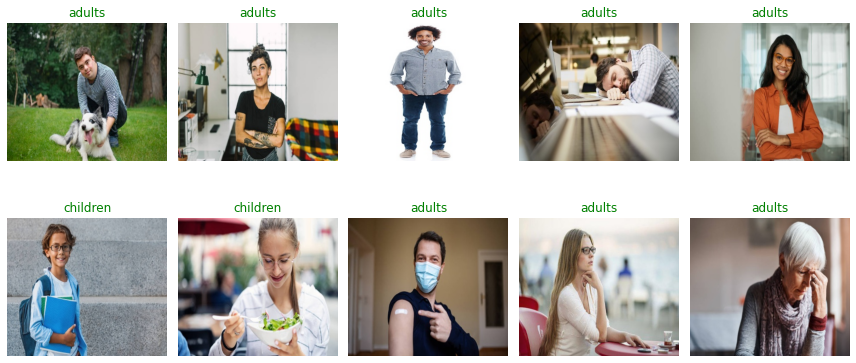

In [12]:
display_image_grid(test_images_filepaths[:10])

In [13]:
# augmentation data calling
train_dataset = AlbumentationImageDataset(images_filepaths=train_images_filepaths, transform=train_transform)
val_dataset = AlbumentationImageDataset(images_filepaths=val_images_filepaths, transform=val_transform)
test_dataset = AlbumentationImageDataset(images_filepaths=test_images_filepaths, transform=test_transform)
# load the data into a batches
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(17, 9))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

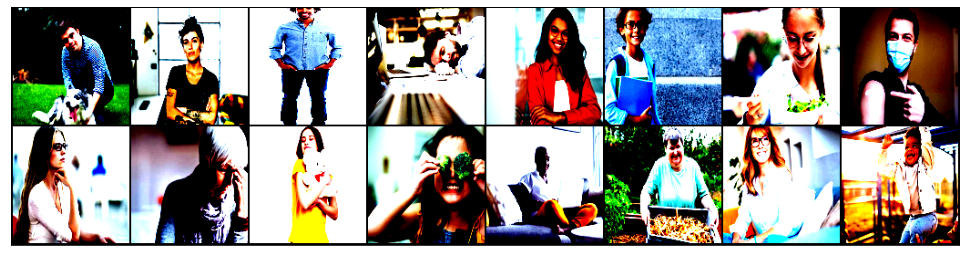

In [15]:
show_batch(test_loader)

In [16]:
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

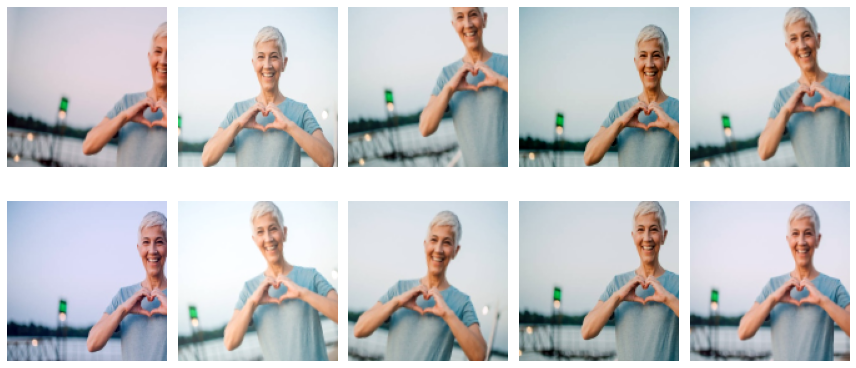

In [17]:
random.seed(42)
visualize_augmentations(train_dataset,idx=60)

In [18]:
#________________________________________________________________# 
#                      Begining of the classe                    #
#________________________________________________________________# 
class ImageClassificationBase(nn.Module):
    
#___________________________________________#
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
#___________________________________________#

#___________________________________________________________________#
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
#___________________________________________________________________#

#______________________________________________________________________________#
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
#______________________________________________________________________________#

#_________________________________________________________________________________________#
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
#_________________________________________________________________________________________#

#________________________________________________________________# 
#                      Ending of the classe                      #
#________________________________________________________________# 

#______________________________________________________________________________#
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
#______________________________________________________________________________#


<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive">  Define Artchitectur CNN Model 👨‍💼🖇️</span></h3>


In [19]:
#________________________________________________________________# 
#                      Begining of the classe                    #
#________________________________________________________________# 
class AdultchildCnnModel(ImageClassificationBase):
    
#_____________________________________________________________________#
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(512*16*16, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
#______________________________________________________________________________#

    def forward(self, xb):
        return self.network(xb)
#________________________________________________________________# 
#                      Ending of the classe                      #
#________________________________________________________________# 

In [20]:
model = AdultchildCnnModel()
model

AdultchildCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=131072, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linea

In [21]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 128, 128])
out.shape: torch.Size([16, 2])
out[0]: tensor([-0.0372, -0.0071], grad_fn=<SelectBackward0>)


In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(AdultchildCnnModel(), device)

In [30]:
len(val_loader)

5

In [27]:
evaluate(model, val_loader)

RuntimeError: expected scalar type Long but found Double

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive">  Test Data 👨‍💻</span></h3>


In [ ]:
valid_tfms = T.Compose([T.ToTensor(), T.Resize((250,250))])
test_dataset = ImageFolder(data_dir+'/test', transform=valid_tfms)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[66]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[61]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
valid_tfms = T.Compose([T.ToTensor(), T.Resize((250,250))])
test_dataset = ImageFolder(data_dir+'/test', transform=valid_tfms)

In [ ]:
test_child

In [ ]:
data_dir = '/kaggle/input/testing/test other'
valid_tfms = T.Compose([T.ToTensor(), T.Resize((250,250))])
test_child = ImageFolder(data_dir, transform=valid_tfms)
img, label = test_child[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[61]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

<h3 id="heading"><span style="background-color:#62d6cc; color:white ; display:fill;border-radius:5px; font-family:cursive"> 🛼🦾Other Approches 📥 </span></h3>

In [ ]:
# def preprocessing_pipeline(data_dir,hyperparameters):
#     """Defines a pipeline for transforming Images data.
#     The input is assumed to be *????* encoded *????*.
#     Attributes:
#         convert_token: The function to apply to input sequence data.
#         pipes: The Pipelines that will be applied to input sequence
#             data in order.
#     """
#     data_transform = transforms.Compose([transforms.RandomCrop((512,512)),
#                                  transforms.ToTensor(),
#                                  transforms.RandomRotation([+90,+180]),
#                                  transforms.RandomRotation([+180,+270]),
#                                  transforms.RandomHorizontalFlip()
#                                 ])
#     dataset = datasets.ImageFolder(path_dir,transform = data_transform)
#     validation_split = 0.15
#     shuffle_dataset = True
#     random_seed = 42dataset_size = len(dataset)
#     indices = list(range(dataset_size))
#     split = int(np.floor(validation_split*dataset_size))
#     if shuffle_dataset:
#         np.random.seed(random_seed)
#         np.random.shuffle(indices)
    
#     train_indices, val_indices = indices[split:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_indices)
#     valid_sampler = SubsetRandomSampler(val_indices)
#     batch_size = 4
#     num_epochs = 10
#     iter_per_ep = len(train_sampler) // batch_size
#     train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,sampler = train_sampler)
#     valid_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,sampler = valid_sampler)

#     return model

In [ ]:
# def load_split_train_test(datadir, valid_size = .2):
#     train_transforms = T.Compose([T.Resize(224),
#                                        T.ToTensor(),
#                                        ])    
#     test_transforms = T.Compose([T.Resize(224),
#                                       T.ToTensor(),
#                                       ])    
#     train_data = datasets.ImageFolder(datadir,       
#                     transform=train_transforms)
#     test_data = datasets.ImageFolder(datadir,
#                     transform=test_transforms)    
#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(np.floor(valid_size * num_train))
#     np.random.shuffle(indices)
#     from torch.utils.data.sampler import SubsetRandomSampler
#     train_idx, test_idx = indices[split:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_idx)
#     test_sampler = SubsetRandomSampler(test_idx)
#     trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=64)
#     testloader = torch.utils.data.DataLoader(test_data,
#                    sampler=test_sampler, batch_size=64)
#     return trainloader, testloader